In [9]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf


#티스토리 업로드시 최적화 코드
#from IPython.core.display import display, HTML
#display(HTML("<style>.container {width:90% !important;}</style>"))

# 2023.05.01
# TRAINING
Dataset Info.

train.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사
    Book-Rating : 유저가 도서에 부여한 평점 (0점 ~ 10점)


test.csv [파일]

    ID : 샘플 고유 ID
    User-ID : 유저 고유 ID
    Book-ID : 도서 고유 ID
    유저 정보
    Age : 나이
    Location : 지역
    도서 정보
    Book-Title : 도서 명
    Book-Author : 도서 저자
    Year-Of-Publication : 도서 출판 년도 (-1일 경우 결측 혹은 알 수 없음)
    Publisher : 출판사


sample_submission.csv [제출양식]

    ID : 샘플 고유 ID
    Book-Rating : 예측한 유저가 도서에 부여할 평점

In [1]:
import pandas as pd

In [2]:
import numpy as np
import random
import os
import gc

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(42) # Seed 고정

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv( 'test.csv')
sample_submission = pd.read_csv('sample_submission.csv', index_col = 0)

In [5]:
train['City'] = [(i.split(',')[0]).lstrip().title() for i in train['Location']]
train['State'] = [(i.split(',')[1]).lstrip().title() for i in train['Location']]
train['Country'] = [(i.split(',')[2]).lstrip().title() for i in train['Location']]

In [6]:
test['City'] = [(i.split(',')[0]).lstrip().title() for i in test['Location']]
test['State'] = [(i.split(',')[1]).lstrip().title() for i in test['Location']]
test['Country'] = [(i.split(',')[2]).lstrip().title() for i in test['Location']]

In [20]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 12.7 MB/s eta 0:00:00


In [7]:
# 나이 그룹화
labels = ['0-3','3-6','6-8','8-12','12-18','18-25','25-34','35-44','45-54','55-64','65-74','75+']
bins = [0, 3, 6, 8, 12, 18, 25, 34, 44, 54, 64, 74, 250]
train['Age_gb'] = pd.cut(train.Age, bins, labels = labels,include_lowest = True)

In [8]:
test['Age_gb'] = pd.cut(test.Age, bins, labels = labels,include_lowest = True)

In [9]:
from sklearn.preprocessing import OrdinalEncoder

FEATURE = ['User-ID', 'Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#,'Topic_num']

train_lb = train.__deepcopy__() 
test_lb = test.__deepcopy__()

#train_lb = pd.merge(train_lb, title, on = 'Book-Title_st', how = 'left')
#test_lb = pd.merge(test_lb, title_t, on = 'Book-Title_st', how = 'left')

train_lb = train_lb.drop(columns = ['Book-ID', 'Location'])
test_lb = test_lb.drop(columns = ['Book-ID', 'Location'])

train_lb[FEATURE] = train_lb[FEATURE].astype(str) 
test_lb[FEATURE] = test_lb[FEATURE].astype(str)

for i in FEATURE:
    # train에는 없고, test에는 있는 원소는 -2 처리
    oe = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=-2)
    oe=oe.fit(train_lb[i].to_numpy().reshape(-1, 1))
    train_lb[i] = oe.transform(train_lb[i].to_numpy().reshape(-1, 1))
    test_lb[i] = oe.transform(test_lb[i].to_numpy().reshape(-1, 1))

In [12]:
X_train = train_lb.drop(columns = ['ID','Book-Rating'])#,'Book-Title_st','City_st','State_st','Country_st'])
y_train = train_lb['Book-Rating']
x_test = test_lb.drop(columns = ['ID'])#,'Book-Title_st','City_st','State_st','Country_st'])

In [13]:
from catboost import CatBoostRegressor 

model = CatBoostRegressor(random_seed = 113,
                          l2_leaf_reg = 0.003426034644149707,
                          max_bin = 358,
                          subsample = 0.9974697184313627,
                          learning_rate = 0.009464402227606937,
                          max_depth = 11,
                          min_data_in_leaf = 139,
                          eval_metric = 'RMSE',
                          iterations = 8694,
                          task_type='GPU',
                          bootstrap_type = 'Poisson',
                          early_stopping_rounds = 100,
                          verbose=500
                          )


Fold  0
0:	learn: 3.8400301	test: 3.8396270	best: 3.8396270 (0)	total: 78.5ms	remaining: 11m 22s
500:	learn: 3.3160830	test: 3.2876170	best: 3.2876170 (500)	total: 54.2s	remaining: 14m 46s
1000:	learn: 3.2730733	test: 3.2685398	best: 3.2685398 (1000)	total: 2m 19s	remaining: 17m 54s
1500:	learn: 3.2429467	test: 3.2607756	best: 3.2607729 (1498)	total: 3m 7s	remaining: 14m 59s
2000:	learn: 3.2173120	test: 3.2566708	best: 3.2566708 (2000)	total: 3m 54s	remaining: 13m 4s
2500:	learn: 3.1934941	test: 3.2535543	best: 3.2535543 (2500)	total: 4m 41s	remaining: 11m 36s
3000:	learn: 3.1707710	test: 3.2513150	best: 3.2513107 (2999)	total: 5m 28s	remaining: 10m 23s
3500:	learn: 3.1487164	test: 3.2498653	best: 3.2498545 (3492)	total: 6m 15s	remaining: 9m 17s
4000:	learn: 3.1275960	test: 3.2488347	best: 3.2488347 (3998)	total: 7m 2s	remaining: 8m 15s
4500:	learn: 3.1066260	test: 3.2481419	best: 3.2481313 (4490)	total: 7m 49s	remaining: 7m 17s
5000:	learn: 3.0862829	test: 3.2475679	best: 3.2475598 (

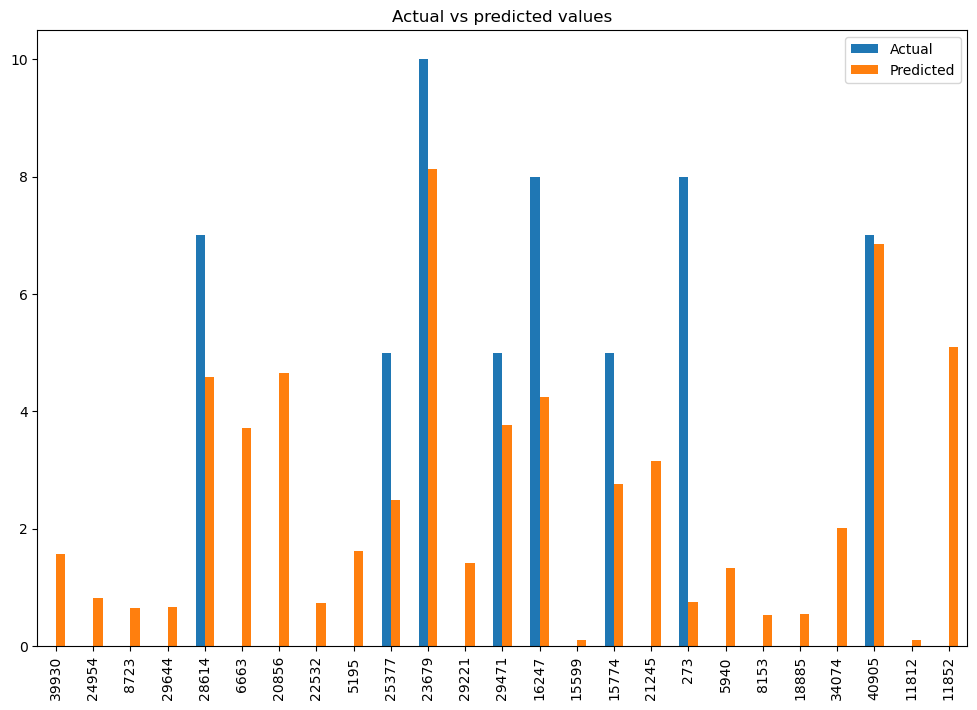

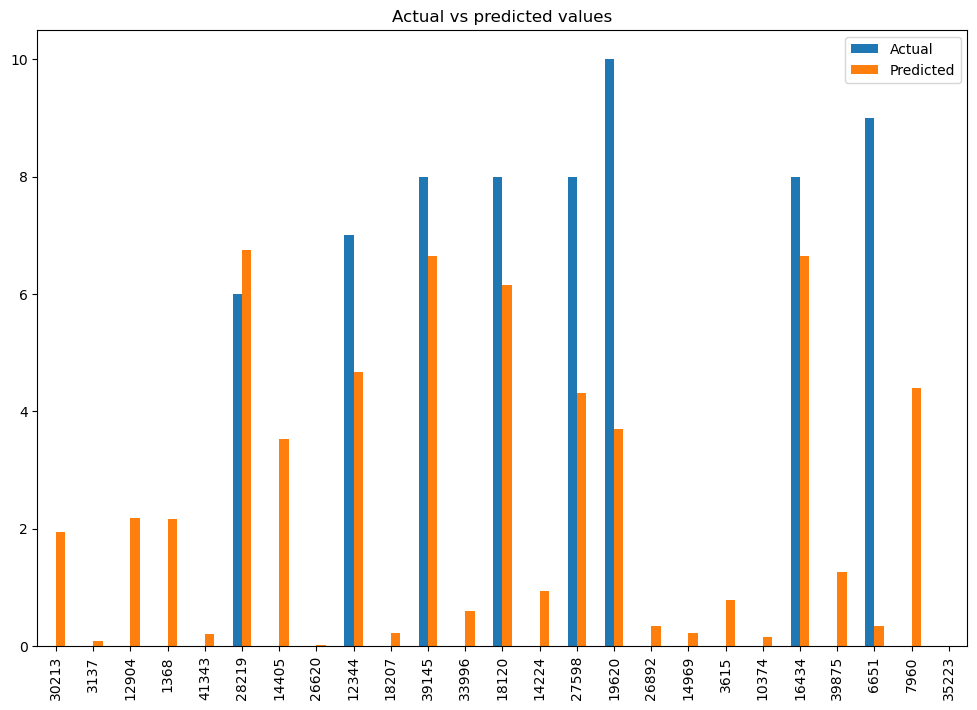

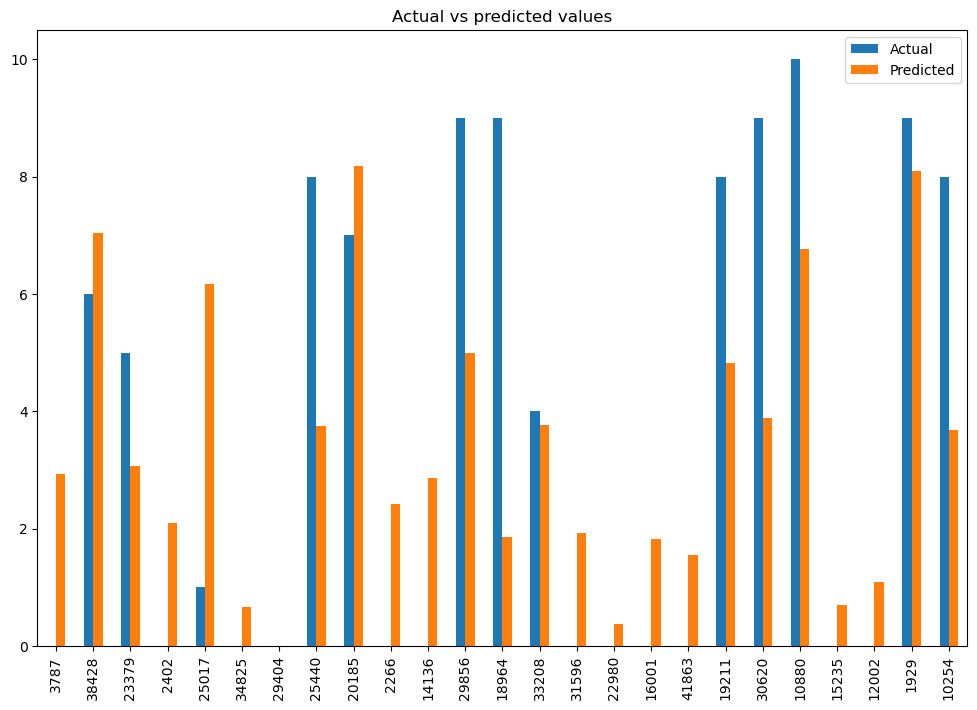

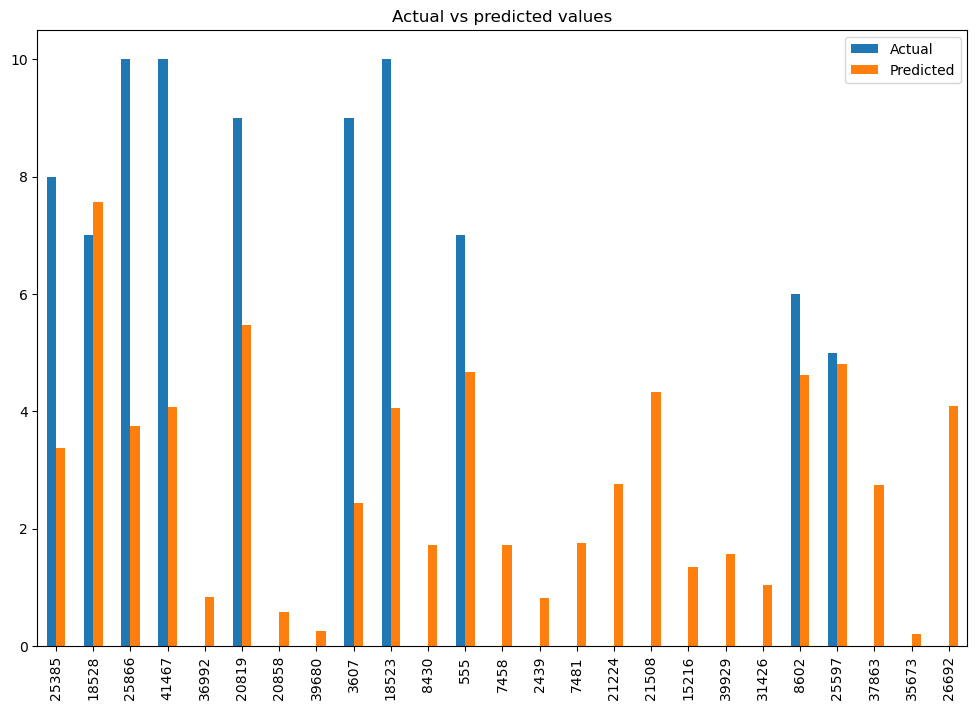

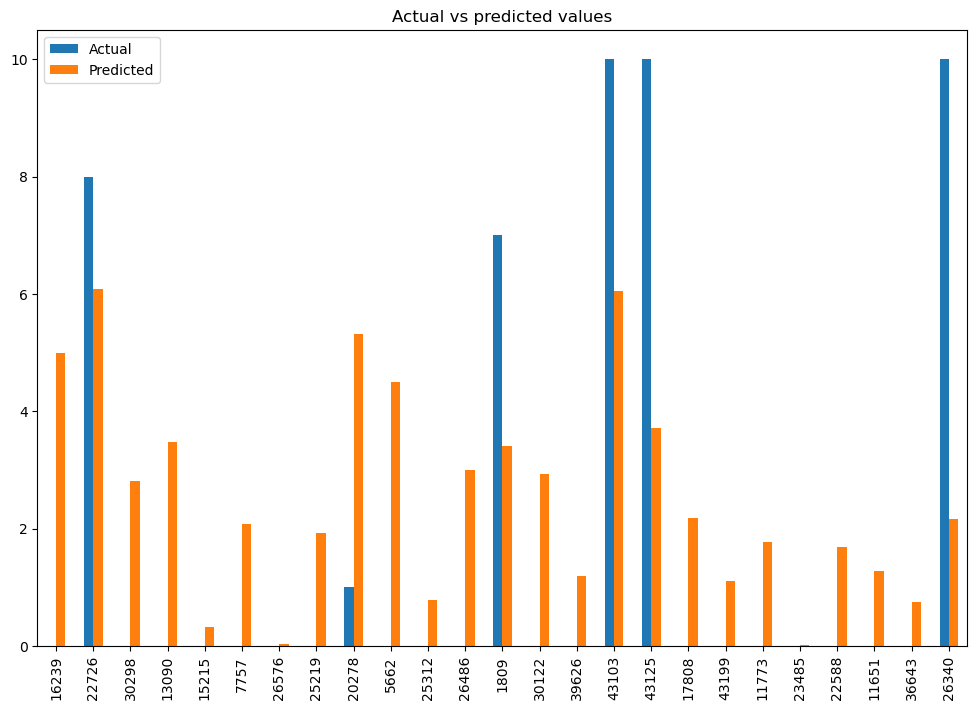

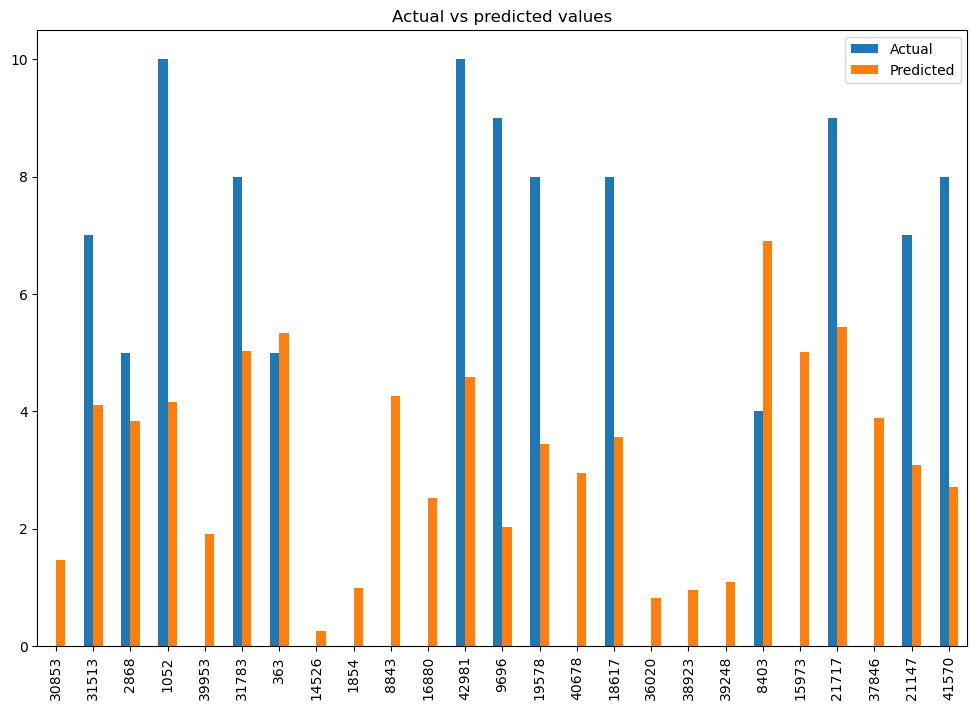

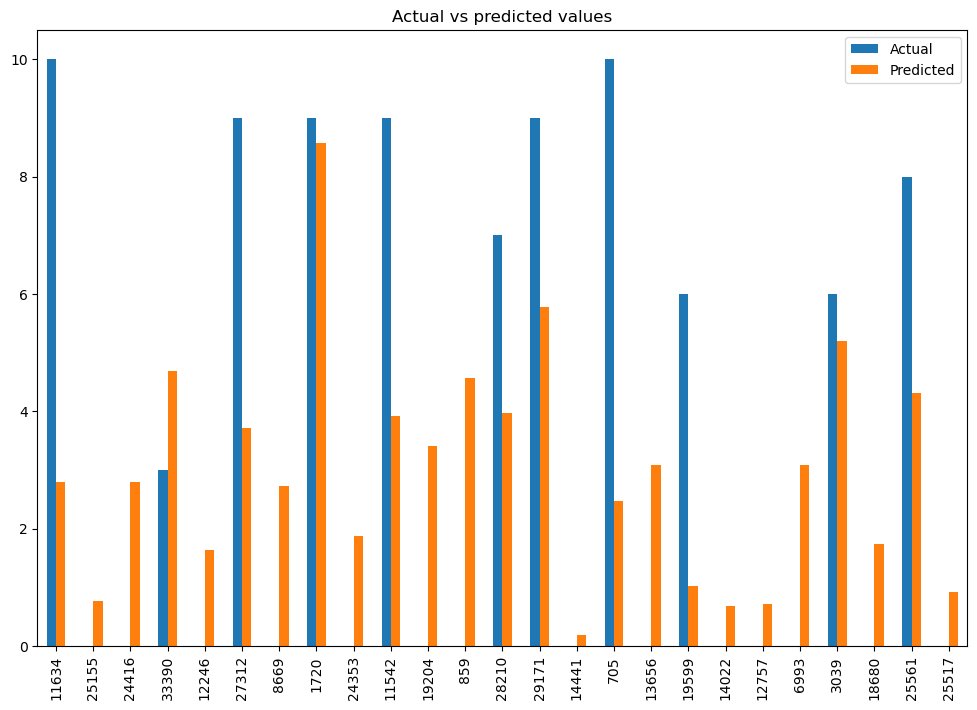

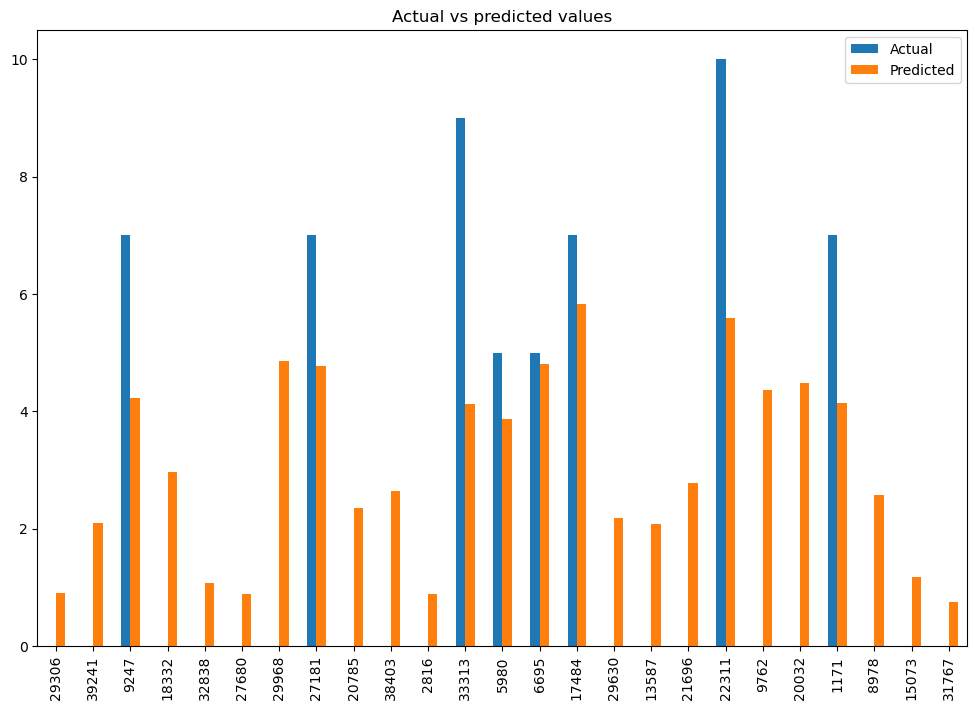

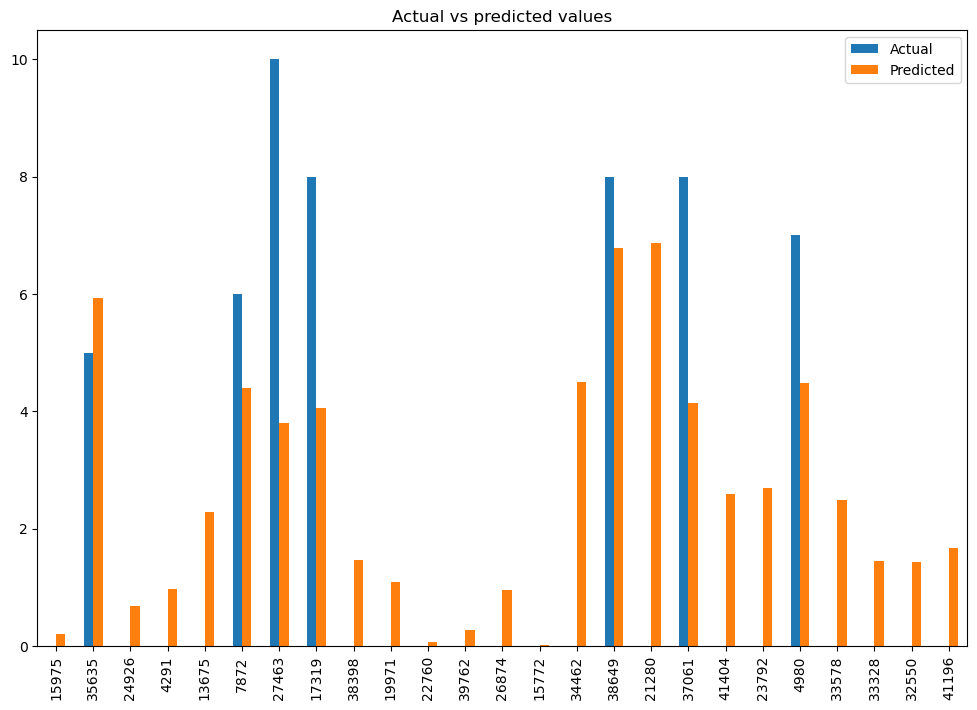

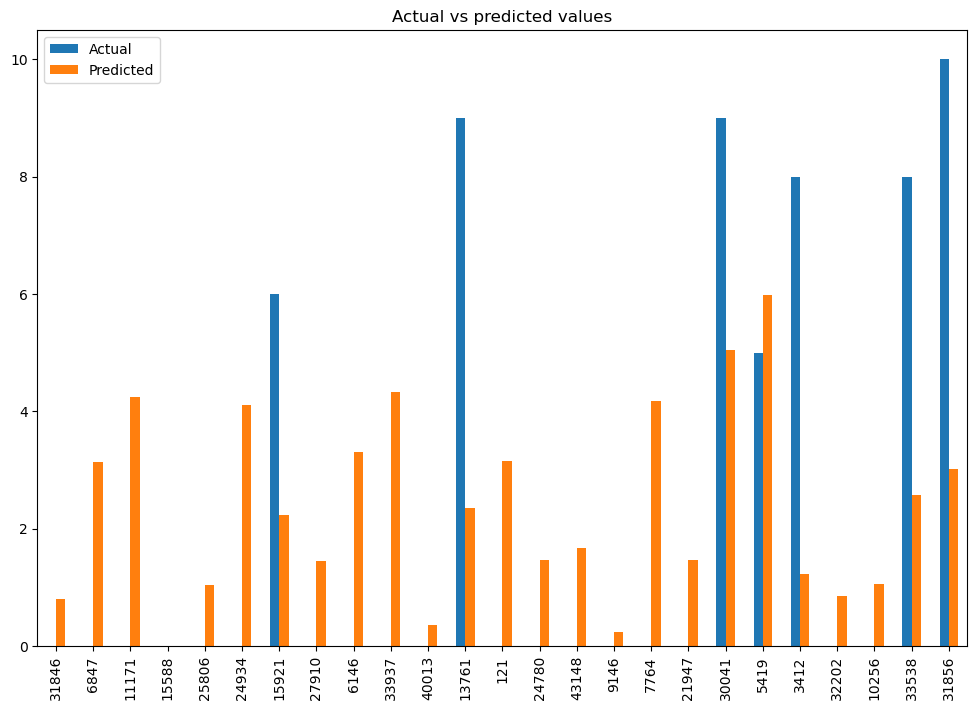

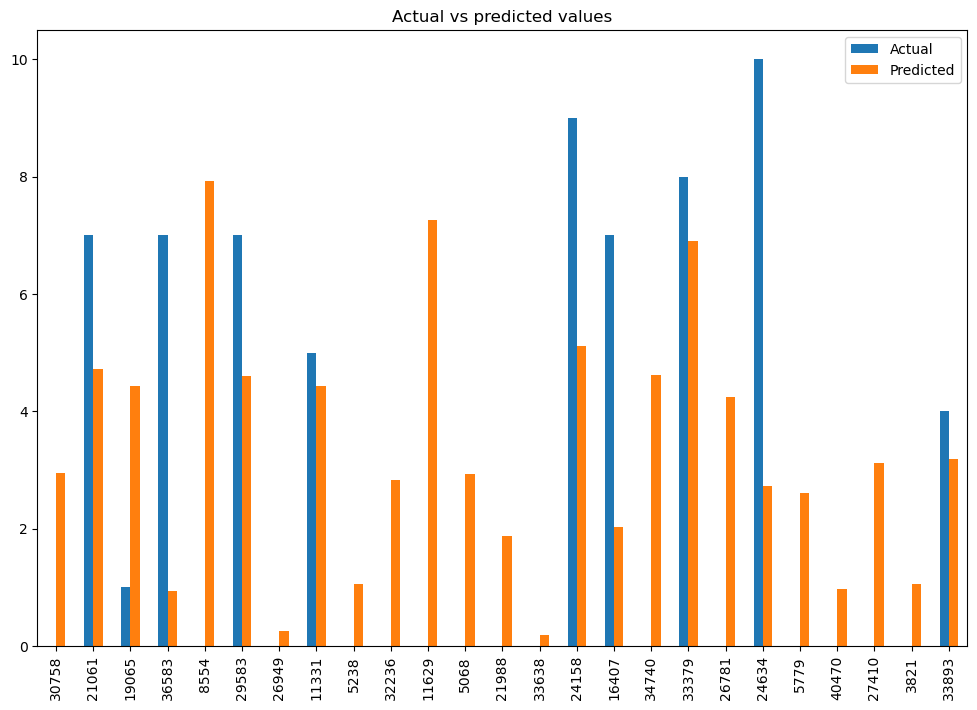

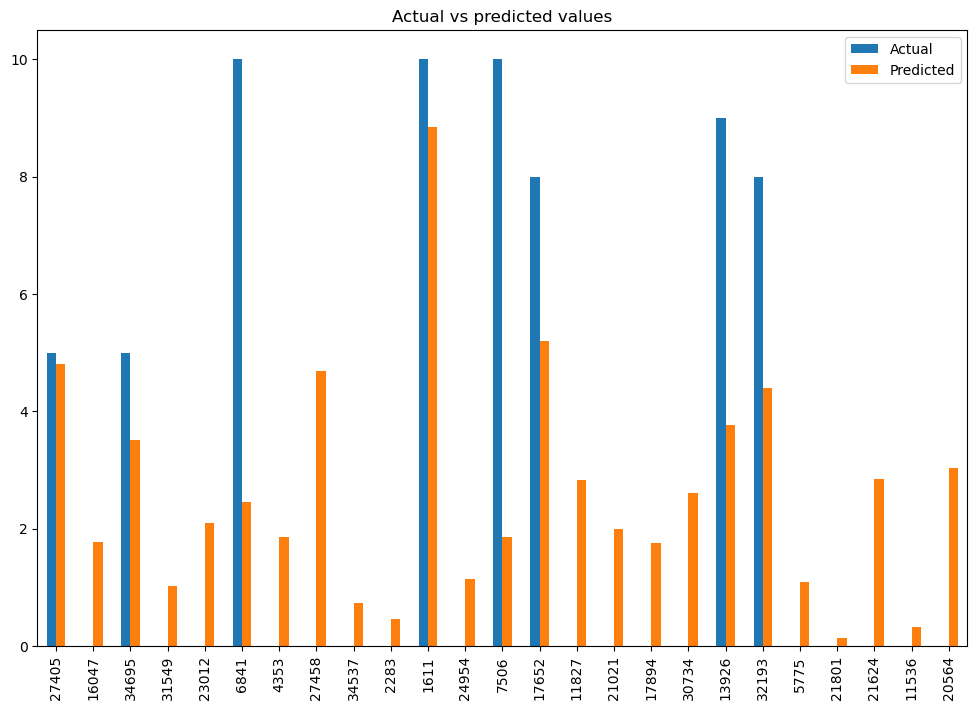

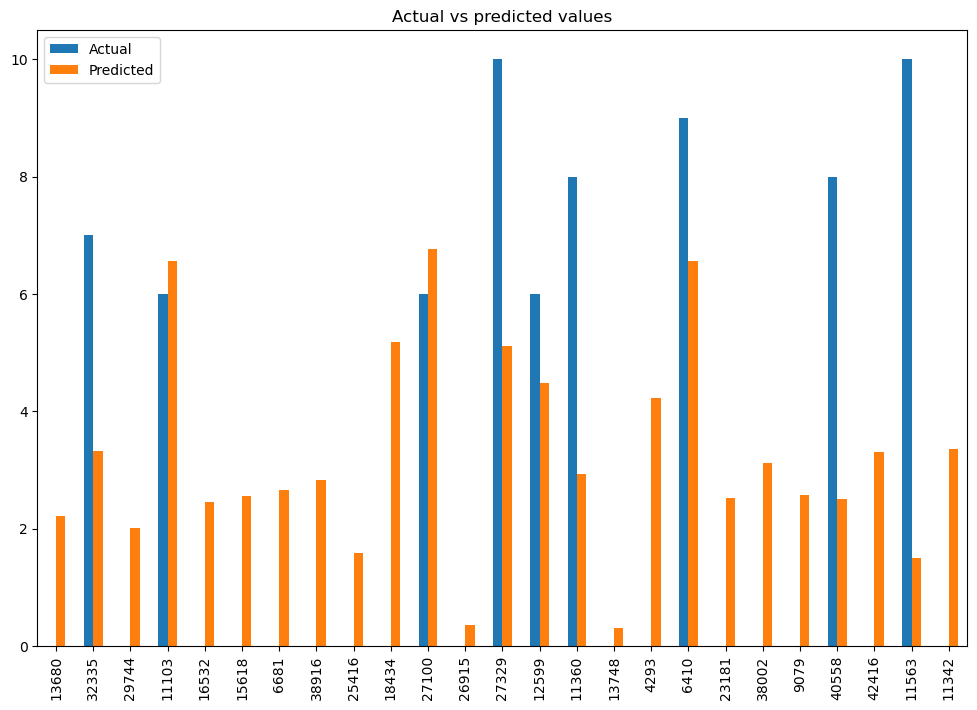

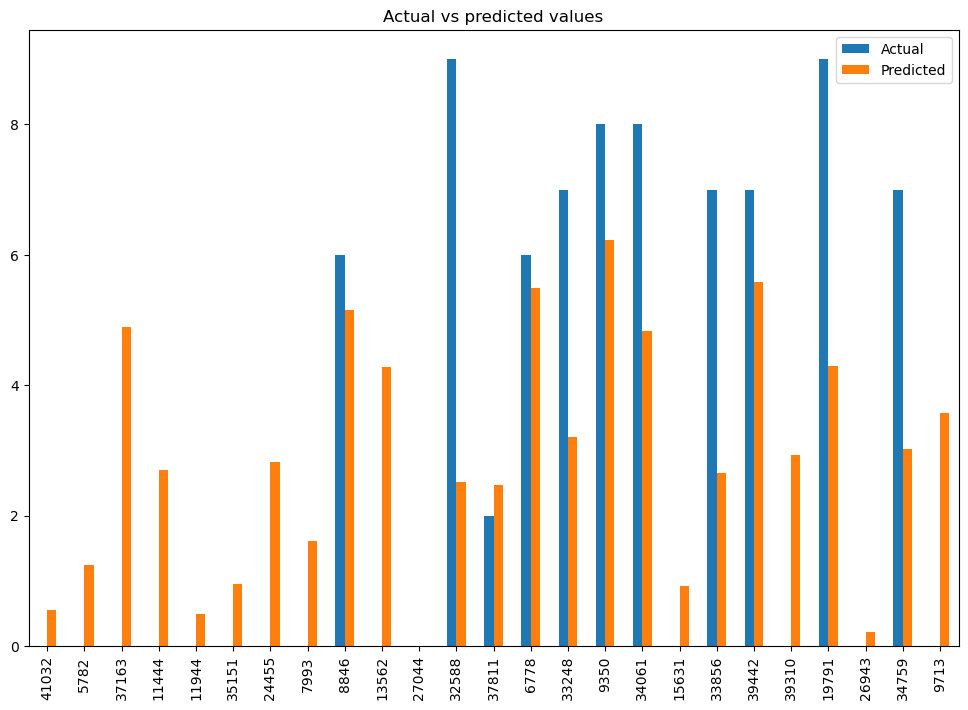

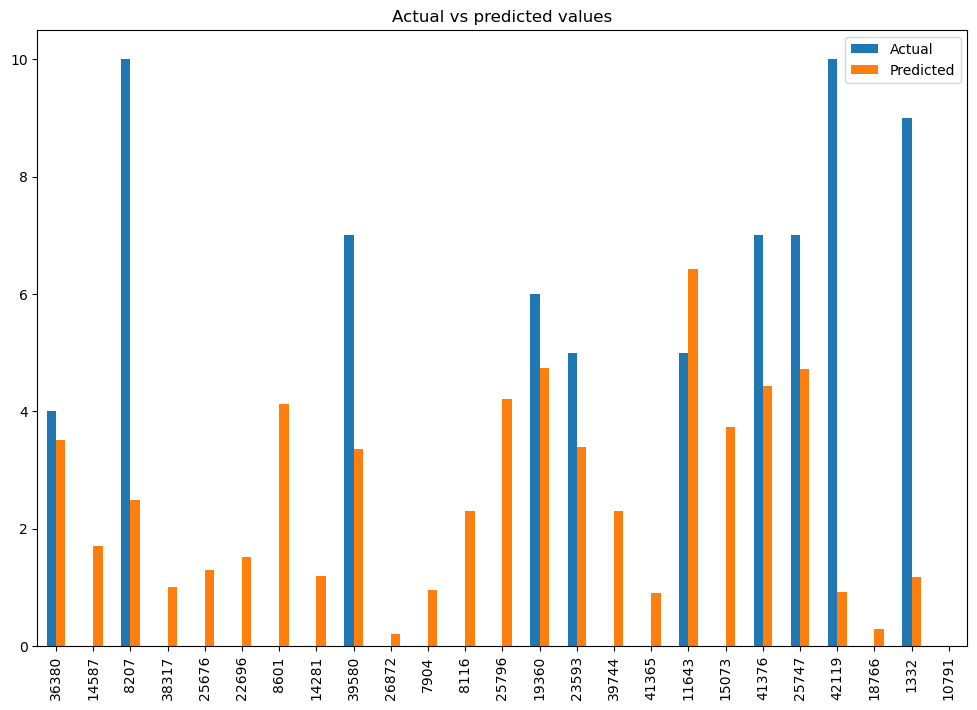

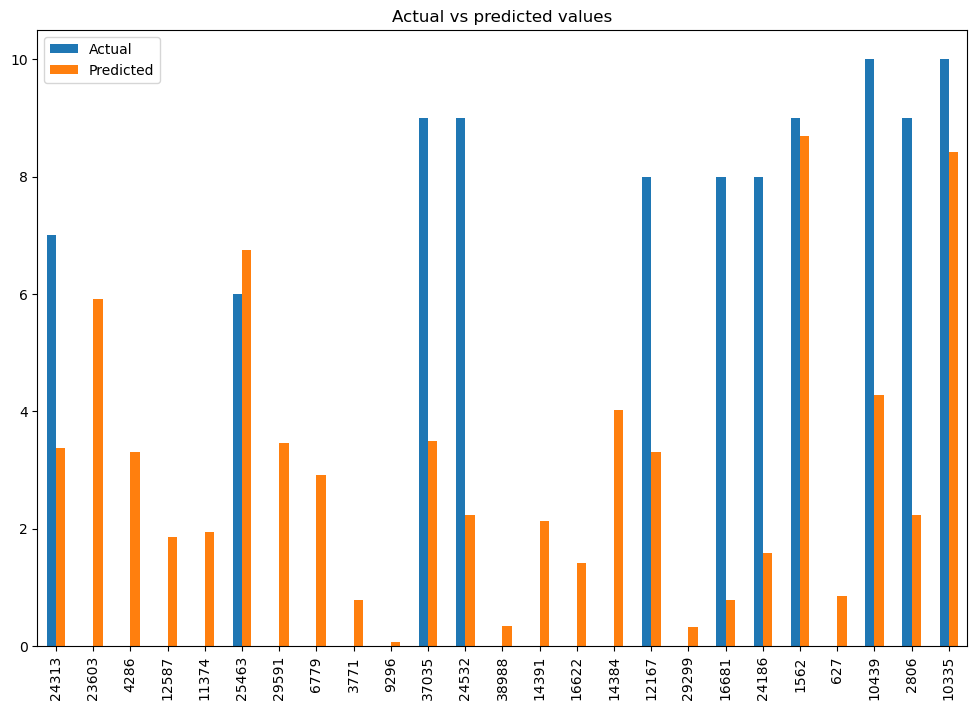

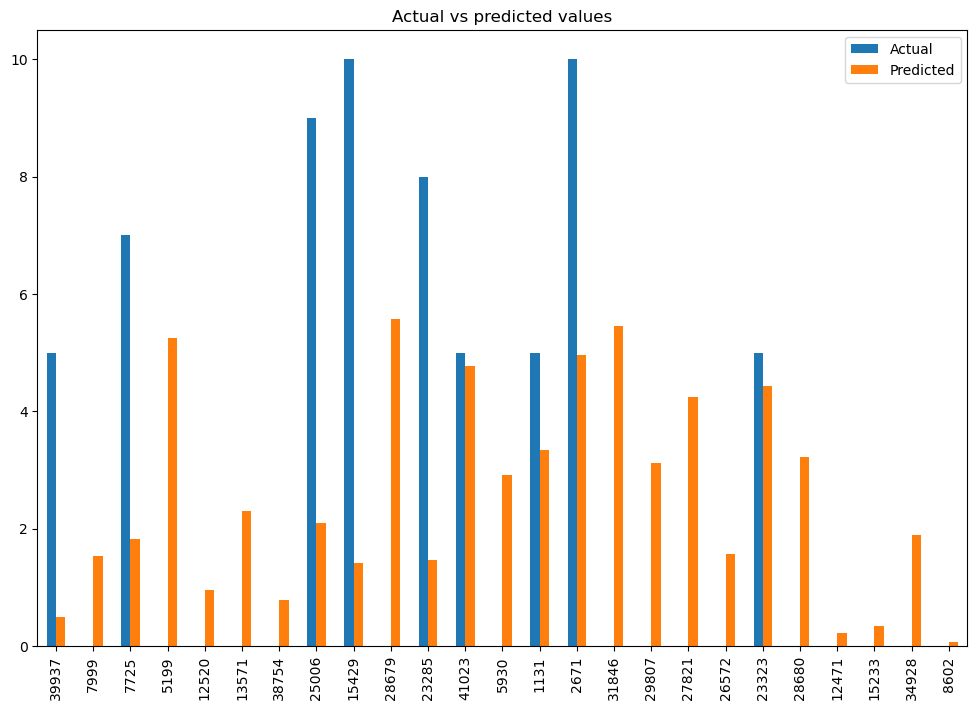

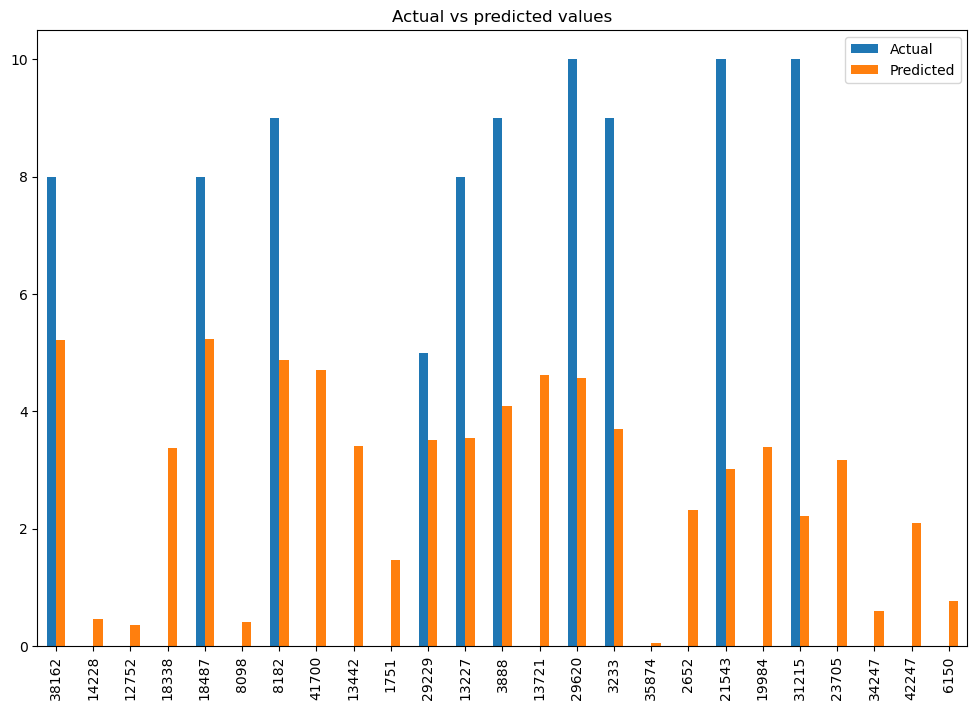

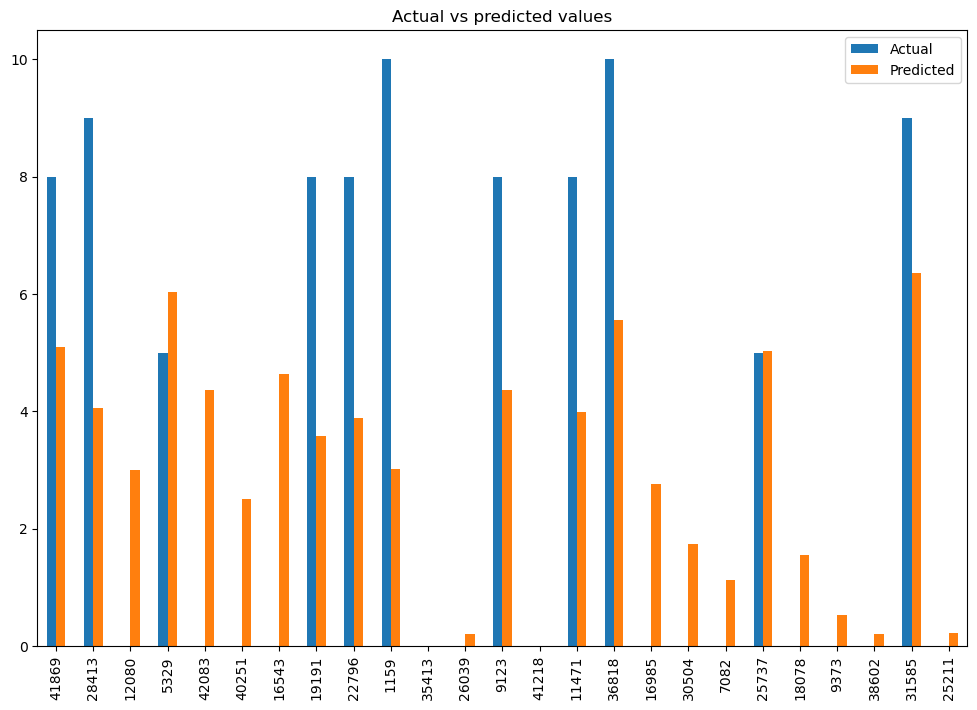

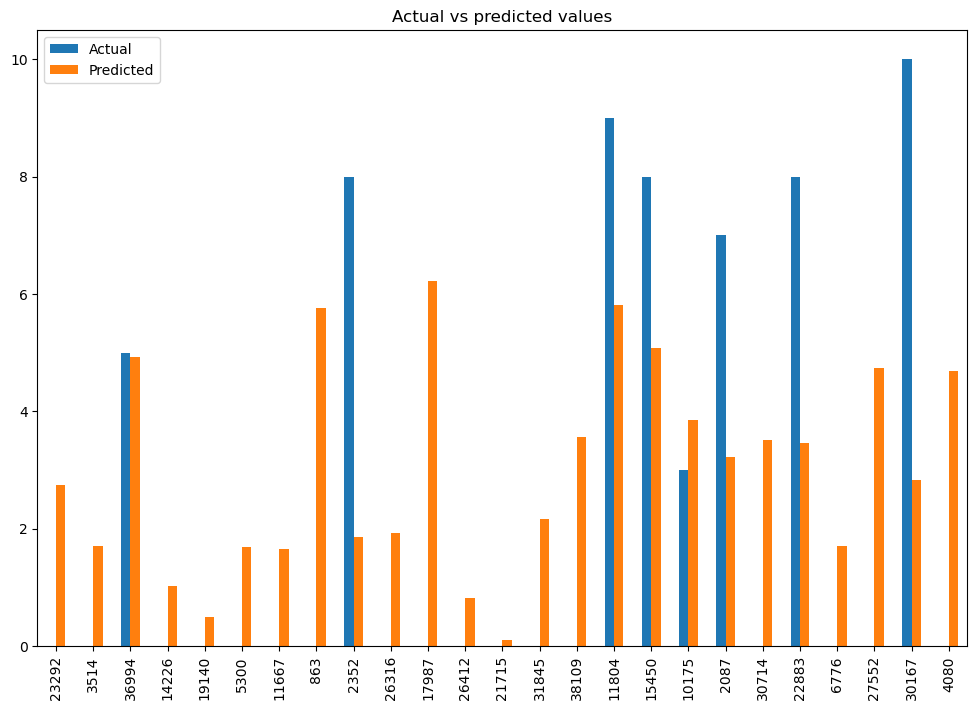

In [14]:
from sklearn.model_selection import KFold, StratifiedKFold

k = 20 # a number of folds 
skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=113)
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from catboost import Pool

y_valid_pred = 0*y_train
y_test_pred = 0

FEATURE = ['User-ID', 'Book-Title','Book-Author','Publisher', 'City','State','Country','Age_gb']#, 'Topic_num']

for i, (train_index, test_index) in enumerate(skfold.split(X_train, y_train)):    
    X_train_fold, X_valid_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_valid_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    train_pool = Pool(data=X_train_fold.astype('int'), label=y_train_fold, cat_features=FEATURE)
    valid_pool = Pool(data=X_valid_fold.astype('int'), label=y_valid_fold, cat_features=FEATURE)

    print( "\nFold ", i)
    
    fit_model = model.fit(train_pool, 
                          eval_set=valid_pool,
                          use_best_model=True
                          )
    print( "  N trees = ", model.tree_count_ )
        
    # Generate validation predictions for this fold
    pred = fit_model.predict(X_valid_fold.astype('int'))
    y_valid_pred.iloc[test_index] = pred

    def score_model(model,X_train, X_test, y_train, y_test,
               show_plot=True):   
        y_pred = np.clip(model.predict(X_test.astype('int')),0,10)
        print(f"Test score: {r2_score(y_test, y_pred)}")
        print("MSE: ", mean_squared_error(y_test, y_pred))
        print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred)))
    
        predictions_comparision = pd.DataFrame({'Actual': y_test.tolist(), 'Predicted': y_pred.tolist()}).sample(25)
        if show_plot == True:
            predictions_comparision.plot(kind="bar", figsize=(12,8),title="Actual vs predicted values")
            print(predictions_comparision.sample(10))    
    
    
        return {
            "test_score_r2" : r2_score(y_test, y_pred),
            "test_score_mse" : mean_squared_error(y_test, y_pred),
            "test_score_rmse" : np.sqrt(mean_squared_error(y_test, y_pred))
            }
    score_model(fit_model, X_train_fold, X_valid_fold, y_train_fold, y_valid_fold, show_plot=True)
    
    # Predict value Clipping
    y_test_pred +=  np.clip(fit_model.predict(x_test[X_valid_fold.columns].astype('int')),0.0,10.0)
    
y_test_pred /= k  # Average test set predictions


In [15]:
sub = pd.DataFrame()
sub['ID'] = test['ID']
sub['Book-Rating'] = y_test_pred
sub

,ID,Book-Rating
0,TEST_000000,5.530954
1,TEST_000001,6.501299
2,TEST_000002,6.203025
3,TEST_000003,5.880463
4,TEST_000004,5.655802
...,...,...
159616,TEST_159616,3.667640
159617,TEST_159617,3.348060
159618,TEST_159618,4.021934
159619,TEST_159619,3.738853


<Axes: xlabel='Book-Rating', ylabel='Count'>

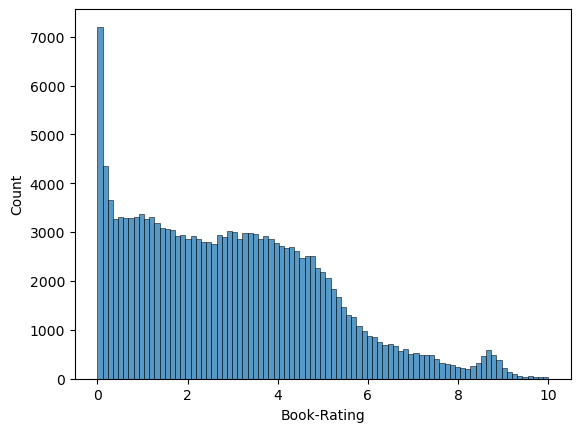

In [16]:
import seaborn as sns
sns.histplot(sub['Book-Rating'])

In [17]:
sub.to_csv('submit_cat+20-folds.csv', index=False,encoding="utf-8-sig")